# Geostatistical Significance of Differences for Spatial Subsurface Phenomenon

**JOSE J. SALAZAR<sup>1</sup>, MICHAEL J. PYRCZ<sup>1,2</sup>**
 
<sup>1</sup> Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering, The University of Texas at Austin, USA

<sup>2</sup>Department of Geological Sciences, Jackson School of Geosciences, The University of Texas at Austin, USA

# Introduction

This Jupyter notebook describes the methods and scripts for the **Geostatistical Significance of Differences for Spatial Subsurface Phenomenon** publication to help reproducibility.

# Imports

## Import packages

Run the following cell to install the [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy) package from Michael J. Pyrcz et al. You will also need [numba](https://pypi.org/project/numba/).

In [1]:
# pip install geostatspy
# pip install numba

Proceed to install other packages used for the publication.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geostatspy.GSLIB as GSLIB          # GSLIB utilities, viz and wrapped functions
import geostatspy.geostats as geostats    # GSLIB converted to Python
import seaborn as sns
import scipy                              # statistics
import scipy.linalg                       # linear algebra library
import math                               # trig, etc.
import random                             # bootstrap
from scipy import stats
# from scipy.stats import ttest_ind as welch     # Welch's t-test for the mean
from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch
import matplotlib.patches as patches
np.warnings.filterwarnings('ignore')

sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
%matplotlib inline

## Functions
Now, we define some useful functions.

In [3]:
def modified_GA(pad1_swarm, pad2_swarm, feature, wellpads, wellpads_x, wellpads_y,
              bootstrap, simulation, case, pad1_swarmnumber, pad2_swarmnumber):
    """
    Function to compute the Gardner-Altman estimation plot
    pad1_swarm, pad2_swarm: DataFrame to plot the swarm plot distribution
    feature: string that is the name of property of interest
    wellpads: DataFrame that has two well pads to plot in the area of interest
    wellpads_x, wellpads_y: column name of the X and Y coordinates of wellpads
    bootstrap: spatial bootstrap
    simulation: np 2D array that is the truth model
    case: number of demonstration from publication (1, 2, or 3)
    pad1_swarmnumber, pad2_swarmnumber: integer that refers to well pads studied for legend
    """
    ################################################
    # Previous computations
    ################################################
    tempo = 'Pad ' + str(pad1_swarmnumber)
    conver = pd.DataFrame(pad1_swarm[feature].to_numpy(), columns=[tempo])
    tempo = 'Pad ' + str(pad2_swarmnumber)
    conver[tempo] = pad2_swarm[feature].to_numpy()
    conver = conver.melt(var_name='Well Pad', value_name=feature)
    pad1_swarm_mean = pad1_swarm[feature].mean()
    pad2_swarm_mean = pad2_swarm[feature].mean()
    effect_size = pad2_swarm_mean - pad1_swarm_mean

    # Compute the percentiles for the 95% CI
    per_up = bootstrap['Difference Means'].quantile(q=0.975)
    per_do = bootstrap['Difference Means'].quantile(q=0.025)
    # Compute the mean of the distribution of differences
    mean = bootstrap['Difference Means'].mean()
    # Minimum and maximum values of porosity
    por_min = np.floor(conver[feature].min())
    por_max = np.ceil(conver[feature].max())
    # Minimum and maximum values of distribution of differences
    df_min = np.floor(bootstrap['Difference Means'].min())
    df_max = np.ceil(bootstrap['Difference Means'].max())
    # left and right axes must be equal. Here we check whether they have the same length; if not, we update it
    len_bootstrap = len(np.arange(df_min, df_max))
    len_property = len(np.arange(por_min, por_max))
    # to check what axis is larger: left or right?
    extra_inc = len_property - len_bootstrap

    if df_min > 0:
        df_min = 0

    ################################################
    # Plotting
    ################################################
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(
        12, 6), gridspec_kw={'width_ratios': [3, 1.2, 1.2]})
    fig.subplots_adjust(left=0.02, bottom=0.1,
                        right=0.95, top=0.99, wspace=0.25)

    ################################################
    # First axis: swarm plots
    ################################################
    sns.swarmplot(x='Well Pad', y=feature, data=conver,
                  size=8, linewidth=2, ax=ax2)
    ax2.set_ylabel(feature, fontsize=14)
    ax2.set_xlabel('', fontsize=14)
    ax2.tick_params(axis='y')

    # Hide the right and top spines
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax2.yaxis.set_ticks_position('left')
    ax2.xaxis.set_ticks_position('bottom')

    ################################################
    # Second Axis: Spatial boootstrap
    ################################################
    sns.distplot(bootstrap['Difference Means'], kde=True,
                 color='blue', vertical=True, ax=ax3).set(xlim=-1)

    ax3.set_ylabel('Mean difference', fontsize=14)
    ax3.set_xlabel('Pad ' + str(pad2_swarmnumber) + ' - Pad ' + str(pad1_swarmnumber), fontsize=12)
    ax3.yaxis.set_label_position("right")
    ax3.plot([0, 0], [per_up, per_do],  'red', linewidth=4)
    ax3.plot(0, mean, 'o', markerfacecolor='black', markeredgecolor='black',
             markeredgewidth=1.0, markersize=10.0)

    ax3.plot(0, effect_size, '*', markerfacecolor='yellow', markeredgecolor='black',
             markeredgewidth=2.0, markersize=15.0, label='Effect size')
    ax3.axis([-1, 1, df_min, df_max])
    ax3.legend(loc=2)

    # Turn off tick labels
    ax3.set_xticklabels([])
    # Hide the left and top spines
    ax3.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    # Only show ticks on the right and bottom spines
    ax3.yaxis.set_ticks_position('right')
    ax3.xaxis.set_ticks_position('bottom')

    # Legend box code from Joe Kington
    # https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot

    # Shrink current axis's height by 10% on the bottom
    box = ax3.get_position()
    ax3.set_position([box.x0, box.y0 + box.height * 0.1,
                      box.width, box.height * 0.9])
    # Put a legend below current axis
    ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07),
               fancybox=True, shadow=True, ncol=5)


    ax3.set_ylim(np.floor(min(df_min, effect_size)),
                 np.ceil(max(df_max, effect_size)))

    ##################################################
    # Add legends
    ##################################################
    ax2.set_ylim(por_min, por_max)
    ax2.plot(0, pad1_swarm_mean, 's', markerfacecolor='yellow', markeredgecolor='black',
             markeredgewidth=2.0, markersize=10.0, label='Pad ' + str(pad1_swarmnumber) + ' mean')
    ax2.plot(1, pad2_swarm_mean, 's', markerfacecolor='yellow', markeredgecolor='black',
             markeredgewidth=2.0, markersize=10.0, label='Pad ' + str(pad2_swarmnumber) + ' mean')

    # Shrink current axis's height by 10% on the bottom
    box = ax2.get_position()
    ax2.set_position([box.x0, box.y0 + box.height * 0.1,
                      box.width, box.height * 0.9])

    # Put a legend below current axis
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07),
               fancybox=True, shadow=True, ncol=5)

    ########################################################################
    # Contour plot
    ########################################################################
    vmin = np.floor(conver[feature].min())
    vmax = np.ceil(conver[feature].max())
    xcol = 'X'
    ycol = 'Y'
    vcol = 'Porosity'
    titles = 'Porosity realization and well pads'
    xlabel = 'X(m)'
    ylabel = 'Y(m)'
    vlabel = 'Porosity (%)'

    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)

    ########################################################################
    # pads
    ########################################################################
    nxwell = 5
    nywell = 2  # number of wells in x and y
    xspace = 50
    yspace = 50  # space in x and y between wells
    # Pad 1
    ox1 = 20
    oy1 = 51  # origin of pad times (x10m) (bottom left corner)
    # Pad 2
    ox2 = 60
    oy2 = 20  # origin of pad (bottom left corner)
    # Pad 3
    ox3 = 63
    oy3 = 70

    ########################################################################
    # Three scenarios are possible
    ########################################################################

    if case == 1 or case == 2:        
        im1 = ax1.scatter(
        wellpads[wellpads_x],
        wellpads[wellpads_y],
        s=None,
        c=wellpads[feature],
        marker=None,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        alpha=0.8,
        linewidths=0.8,
        edgecolors='black'
    )

        cb = fig.colorbar(im1, orientation="horizontal", ax=ax1,
                          label='Porosity %', pad=0.1, fraction=0.05)
        lista = list(np.linspace(vmin, vmax, 5))
        cb.set_ticks(lista)
        cb.set_ticklabels(lista)
        
        
        ax1.add_patch(Rectangle((ox1*10*1.03, oy1*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1,
                                color='black', linewidth=1.0, alpha=0.1, facecolor=None))
        ax1.add_patch(Rectangle((ox2*10*1.03, oy2*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1,
                                color='black', linewidth=1.0, alpha=0.1, facecolor=None))
        
        ax1.text(290, 650, 'Pad 1', fontsize = 15)
        ax1.text(700, 350, 'Pad 2', fontsize = 15)
        
    elif case == 3:
        im1 = ax1.scatter(
        wellpads[wellpads_x],
        wellpads[wellpads_y],
        s=None,
        c=wellpads[feature],
        marker=None,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        alpha=0.8,
        linewidths=0.8,
        edgecolors='black'
    )
        cb = fig.colorbar(im1, orientation="horizontal", ax=ax1,
                          label='Porosity %', pad=0.1, fraction=0.05)
        lista = list(np.linspace(vmin, vmax, 5))
        cb.set_ticks(lista)
        cb.set_ticklabels(lista)
        
        ax1.add_patch(Rectangle((ox1*10*1.03, oy1*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1,
                                color='black', linewidth=1.0, alpha=0.1, facecolor=None))
        ax1.add_patch(Rectangle((ox3*10*1.03, oy3*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1,
                                color='black', linewidth=1.0, alpha=0.1, facecolor=None))
    
        ax1.text(290, 650, 'Pad 1', fontsize = 15)
        ax1.text(750, 850, 'Pad 3', fontsize = 15)

    elif case == 4:
        ########################################################################
        # Extra wells outside the pads
        ########################################################################
        ax1.add_patch(Rectangle((ox1*10*1.03, oy1*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1,
                                color='black',linewidth=1.0, alpha=0.1, facecolor=None))
        ax1.add_patch(Rectangle((ox2*10*1.03, oy2*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1,
                                color='black',linewidth=1.0, alpha=0.1, facecolor=None))
        
        ax1.text(290, 450, 'Pad 1', fontsize = 15)
        ax1.text(700, 150, 'Pad 2', fontsize = 15)
        
        previous_wells_x = np.array([925, 585, 175, 525, 915, 195, 765, 345, 505])
        previous_wells_y = np.array([275,275, 585, 585, 355, 485, 355,675, 405])
        previous_wells = pd.DataFrame(data=previous_wells_x, columns=['X'])
        previous_wells['Y'] = previous_wells_y
        
        previous_wells_x = np.ceil(previous_wells_x/10)-1
        previous_wells_y = np.ceil(previous_wells_y/10)-1
        tempo = []
        for i, j in zip(previous_wells_x, previous_wells_y):
            tempo.append(combined_model.ravel()[(100) * int(j) + int(i)])

        previous_wells['Porosity'] = tempo
        
        previous_wells['Type'] = 'Existing'
        wellpads['Type'] = 'Prospective'
        tempo = pd.concat([previous_wells, wellpads], axis=0)
        
        vmin = tempo['Porosity'].min()
        vmax = tempo['Porosity'].max()
        
        im1 = ax1.scatter(
            tempo[tempo['Type']=='Existing']['X'].to_numpy(),
            tempo[tempo['Type']=='Existing']['Y'].to_numpy(),
            s=None,
            c=tempo[tempo['Type']=='Existing']['Porosity'].to_numpy(),
            marker='s',
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            alpha=0.8,
            linewidths=0.8,
            edgecolors='black',
            label='Prior Data'
            )
        
        ax1.scatter(
            tempo[tempo['Type']=='Prospective']['X'].to_numpy(),
            tempo[tempo['Type']=='Prospective']['Y'].to_numpy(),
            s=None,
            c=tempo[tempo['Type']=='Prospective']['Porosity'].to_numpy(),
            marker='o',
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            alpha=0.8,
            linewidths=0.8,
            edgecolors='black',
            label='New Data'
            )
        
        cb = fig.colorbar(im1, orientation="horizontal", ax=ax1,
                          label='Porosity %', pad=0.1, fraction=0.05)
        ax1.legend(prop={'size': 14})

    else:
        print('Please enter a valid option')

    plt.show()
    fig.savefig('Fig.tiff', dpi=400, format="tiff", bbox_inches='tight')

Let's define a function to sample data from a well. [Pyrcz](https://github.com/GeostatsGuy/RepeatableResearch/blob/master/Gussow_Model_Resample_Pyrcz.ipynb) offers a great example:

In [4]:
# extract pad samples from a model   
def extract_pad_sample(array,xmin,xmax,ymin,ymax,step,ox,oy,xspace,yspace,nxwell,nywell,name):
    x = []; y = []; v = []; iix = 0; iiy = 0;
    ixspace = int(xspace / step)
    iyspace = int(yspace / step)
    iiy = 0
    for iy in range(0,iyspace*nywell+1):
        if iiy >= iyspace:
            iix = 0
            for ix in range(0,ixspace*nxwell+1):
                if iix >= ixspace:
                    cx = ox + ix; cy = oy + iy 
                    x.append(step*(float(cx)-0.5)); y.append(step*(float(cy)-0.5)); v.append(array[ny-cy+1,cx])
                    iix = 0; iiy = 0
                iix = iix + 1
        iiy = iiy + 1
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)

To impose a geological trend, we will use a [bivariate normal distribution](http://mathworld.wolfram.com/BivariateNormalDistribution.html) window.

In [5]:
def multi_gaussian(rho, mean1, mean2, std1, std2, x1,x2):
    """
    rho: correlation coefficient. Between -1 and 1
    mean1: mean of variable 1. Use it to center the Gaussian window
    mean2: mean of variable 2. Use it to center the Gaussian window
    std1: standard deviation of variable 1. Spread of the window
    std2: standard deviation of variable 2. Spread of the window
    x1: variable 1
    x2: variable 2
    """
    z = ((x1-mean1)**2)/std1**2 - (2*rho*(x1-mean1)*(x2-mean2))/(std1 * std2) + ((x2-mean2)**2)/std2**2
    prob = np.exp(-z/(2*(1-rho**2)))/(2* np.pi * np.sqrt(1 - rho))/(std1 * std2)
    return prob

Let's define a folder where we will store the archives.

# Demonstration I: Geostatistical significance to assess difference under the assumption of feature stationarity

## Porosity realizations
We will now simulate porosity data to populate an array of shape 100x100. First, we need to establish the modeling parameters.

In [6]:
# Modeling parameters, the model grid, the random seed, the target distribution, and color bar

nx = 100; ny = 100; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0                                           # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model
seed = 11                                                        # random number seed  for stochastic simulation   
range_max = 100; range_min = 10; azimuth = 45                   # Porosity variogram ranges and azimuth
mean = 15.0; stdev = 1.5                                         # Porosity mean and standard deviation
cmap = plt.cm.inferno                                            # using the plasma color map

Then, we have to define the spatial continuity of our model; i.e., define the variogram. Next, we proceed with the simulation. If you did not see it before, the simulation uses a range (90) that is less than 1/10 of the extent of the model (1000 m).

After the simulattion we use `GSLIB.affine` to shift the distribution with the values of mean and standard deviation we want.

In [7]:
vario = GSLIB.make_variogram(nug=0, nst=1, it1=1, cc1=1.0, azi1=azimuth, hmaj1=90, hmin1=70)
sim = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed, vario, 'simulation')

sim = GSLIB.affine(sim, mean, stdev)              # correct the distribution to a target mean and standard deviation.

Finally we plot the simulation and the two well pads. Recall that the simulation is our true model

We also will sample the porosity values from wells using this realization.

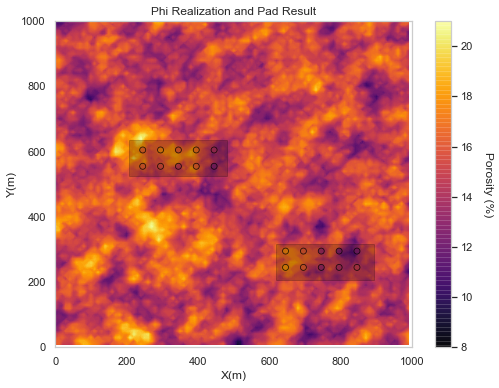

In [8]:
# This is the example realization with pads for the above Figure
# Pad 1
ox = 20; oy = 51 # origin of pad times (x10m) (bottom left corner)
nxwell = 5; nywell = 2 # number of wells in x and y
xspace = 50; yspace = 50 # space in x and y between wells
pad1 = extract_pad_sample(sim, xmin, xmax, ymin, ymax, cell_size, ox=ox, oy=oy, xspace=xspace, yspace=yspace,
                          nxwell=nxwell, nywell=nywell, name='Porosity')
# Pad 2
ox2 = 60; oy2 = 20 # origin of pad (bottom left corner)
nxwell2 = 5; nywell2 = 2 # number of wells in x and y
xspace2 = 50; yspace2 = 50 # space in x and y between wells
pad2 = extract_pad_sample(sim, xmin, xmax, ymin, ymax, cell_size, ox=ox2, oy=oy2, xspace=xspace2, yspace=yspace2,
                          nxwell=nxwell2, nywell=nywell2, name='Porosity')

pad = pd.concat([pad1,pad2],axis=0)

plt.figure(figsize=(8, 6))
GSLIB.locpix_st(sim, xmin, xmax, ymin, ymax, cell_size, np.floor(np.min(sim)), np.ceil(np.max(sim)), pad,
                'X','Y','Porosity','Phi Realization and Pad Result', 'X(m)', 'Y(m)','Porosity (%)',cmap)
plt.gca().add_patch(Rectangle((ox*10*1.03, oy*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1, color='black',
                              linewidth = 1.0,alpha=0.2,facecolor = None))
plt.gca().add_patch(Rectangle((ox2*10*1.03, oy2*10*1.03), width=xspace2*nxwell2*1.1, height=yspace2*nywell2*1.1, color='black',
                              linewidth = 1.0,alpha=0.2,facecolor = None))

plt.show()

Let's assign the well number to the index of each `DataFrame` containing the information for each well pad. The well index is obtained the Fortran-style order using `ravel()`.

In [9]:
index1 = []; index2 = []
for phi in np.arange(0, len(pad1)):
    index1.append(np.where(sim.ravel() == pad1.iloc[phi,2])[0][0])
    index2.append(np.where(sim.ravel() == pad2.iloc[phi,2])[0][0])

pad1.index = index1
pad2.index = index2

## Stationary realizations of porosity

In [10]:
realizations = np.zeros((9, 100, 100))
seeds = np.random.randint(14, high=500, size=9)
for real_i, seed in enumerate(seeds):
    
    realizations[real_i, :, :] = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed, vario, 'simulation')

    realizations[real_i, :, :] = GSLIB.affine(realizations[real_i, :, :], mean, stdev)

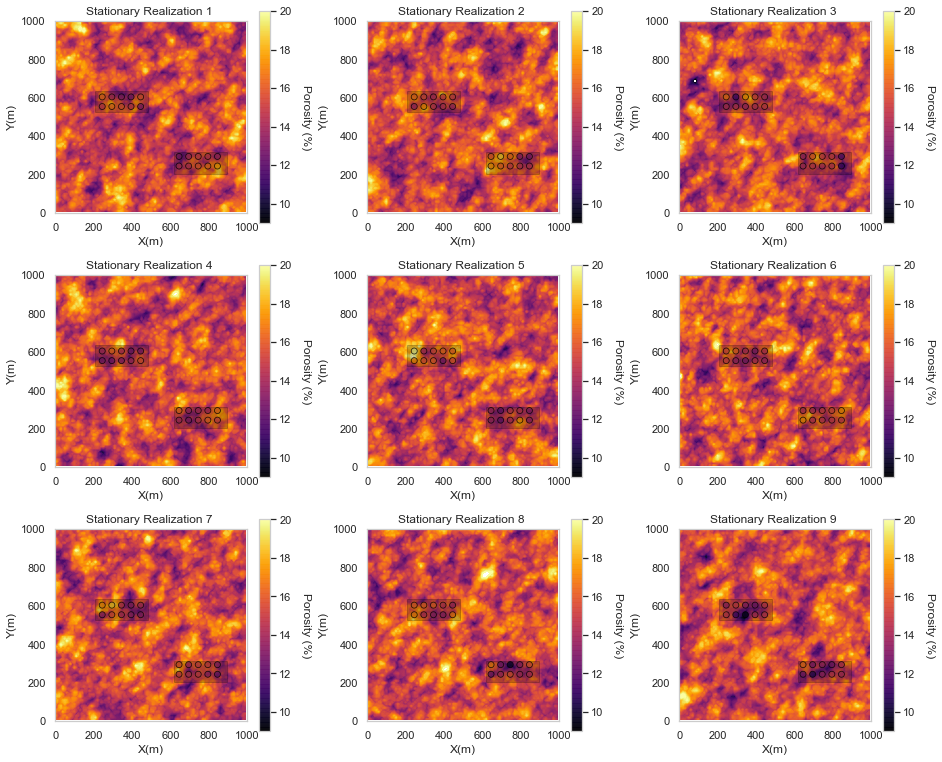

In [11]:
for real_i in range(9):
    plt.subplot(3,3,real_i+1,aspect="equal")
    
    # This is the example realization with pads for the above Figure
    # Pad 1
    ox = 20; oy = 51 # origin of pad times (x10m) (bottom left corner)
    nxwell = 5; nywell = 2 # number of wells in x and y
    xspace = 50; yspace = 50 # space in x and y between wells
    pad1i = extract_pad_sample(realizations[real_i, :, :], xmin, xmax, ymin, ymax, cell_size, ox=ox, oy=oy, xspace=xspace, yspace=yspace,
                              nxwell=nxwell, nywell=nywell, name='Porosity')
    # Pad 2
    ox2 = 60; oy2 = 20 # origin of pad (bottom left corner)
    nxwell2 = 5; nywell2 = 2 # number of wells in x and y
    xspace2 = 50; yspace2 = 50 # space in x and y between wells
    pad2i = extract_pad_sample(realizations[real_i, :, :], xmin, xmax, ymin, ymax, cell_size, ox=ox2, oy=oy2, xspace=xspace2, yspace=yspace2,
                              nxwell=nxwell2, nywell=nywell2, name='Porosity')

    padi = pd.concat([pad1i,pad2i],axis=0)

    GSLIB.locpix_st(realizations[real_i, :,:],xmin,xmax,ymin,ymax,cell_size,9,20,padi,'X','Y',
                    'Porosity',"Stationary Realization {0:2s}".format(str(real_i+1)),'X(m)','Y(m)','Porosity (%)',cmap)
    plt.gca().add_patch(Rectangle((ox*10*1.03, oy*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1, color='black',
                              linewidth = 1.0,alpha=0.2,facecolor = None))
    plt.gca().add_patch(Rectangle((ox2*10*1.03, oy2*10*1.03), width=xspace2*nxwell2*1.1, height=yspace2*nywell2*1.1, color='black',
                                  linewidth = 1.0,alpha=0.2,facecolor = None))
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.3, hspace=0.2)
plt.show()

## Resampling using spatial bootstrap

Now let's perform the spatial bootstrap using [Journel's](https://link.springer.com/article/10.1007%2FBF00714200) approach. Perform *enough* realization using the previous parameters, changing only the seed number.
1. Sample at the well pad locations for each realization from 1
2. Compute the mean for each well pad from 2
3. Repeat 1 and 2
4. After computing all the realizations, substract the mean 2 from mean 1

The greater the number of realizations `num_sim`, the longer it will take to run.

In [12]:
num_sim = 10 # number of sim_is

# create the DataFrame that will store all results
sampling_dist = pd.DataFrame(np.zeros((num_sim, 3)), columns=['N1 Mean', 'N2 Mean', 'Difference Means'])

means_diff = np.zeros((num_sim, 1)) # initialize the array where you will store the difference of means
n_eff = np.zeros_like(means_diff) # initialize the array where you will store the average n effective

for sim_i in range(0, num_sim):
    sim = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed+sim_i, vario, 'sim_i')
    sim = GSLIB.affine(array=sim, tmean=15, tstdev=1.5) # correct the distribution to a target mean and standard deviation
    
    ############################################################
    ## Compute the means of the data sampling sets
    ############################################################
    mean1 = np.mean(sim.ravel()[pad1.index.values])
    mean2 = np.mean(sim.ravel()[pad2.index.values])
    sampling_dist.iloc[sim_i, 0] = mean1
    sampling_dist.iloc[sim_i, 1] = mean2

############################################################
## Final computations
############################################################
sampling_dist['Difference Means'] = sampling_dist['N2 Mean'] - sampling_dist['N1 Mean'] # compute difference of the means

Instead of sampling 10,000 times the above code (computer intensive), read the pickle file that contains the result.

In [13]:
sampling_dist = pd.read_pickle("./Demonstration1.pkl")
sampling_dist['Difference Means'] = sampling_dist['N2 Mean'] - sampling_dist['N1 Mean']

## Estimation plots

Compute the [Gardner-Altman plot](https://en.wikipedia.org/wiki/Estimation_statistics#Gardner-Altman_plot) for some porosity values from the well pads (recall, it is a pre-drill assessment so they are not real data).

The proposed and modified Gardner-Altman plot presents three primary results:

1. On the left, it shows the locations of the two well pads within the area of interest and well average porosity.

2. All datapoints are presented as a swarmplot, which orders each point to display the underlying distribution.

3. On the right the mean of the null distribution is represented by a black dot and the observed effect size _µ2-µ1_ as a yellow star

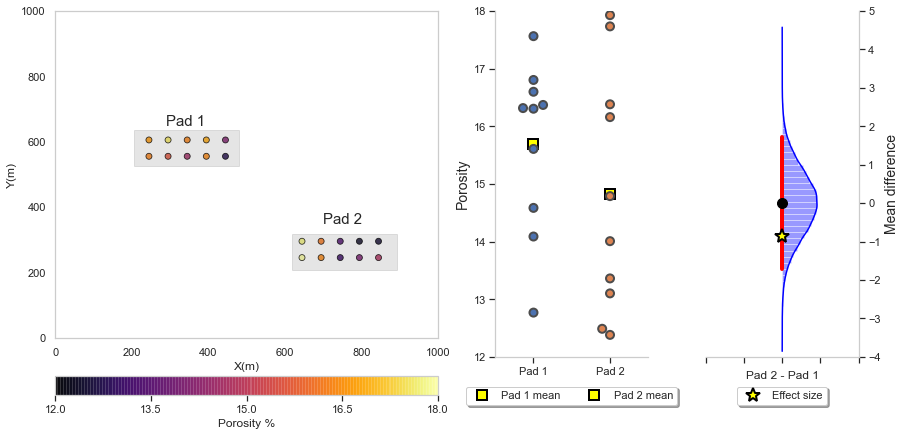

In [14]:
modified_GA(pad1, pad2, 'Porosity', pad, 'X', 'Y', sampling_dist,
            simulation=sim, case=1, pad1_swarmnumber=1,
            pad2_swarmnumber=2)

The mean difference between Pad 1 and Pad 2 is shown in the above Gardner-Altman estimation plot. Both groups are plotted on the left axes; the mean difference is plotted on a floating axes on the right as a spatial bootstrap sampling distribution. The mean difference is depicted as a dot; the 95% confidence interval is indicated by the ends of the vertical error bar.
Credit to [estimationestats.com](https://www.estimationstats.com/#/analyze/two-independent-groups).

## Critical statistics
Let's compute the critical statistics for the 95% $\alpha$ level

In [15]:
############################################################
## Critical values (empirical)
############################################################
per_up_05 = sampling_dist['Difference Means'].quantile(q=0.975);
per_down_05 = sampling_dist['Difference Means'].quantile(q=0.025)

print('{0:5^s}'.format('CONFIDENCE INTERVAL'))
print('The 95% CI: {0:0.2f} < \u03BC1-\u03BC2 < {1:0.2f}'.format(per_down_05, per_up_05))

CONFIDENCE INTERVAL
The 95% CI: -1.71 < μ1-μ2 < 1.71


Our observed difference is the difference in porosity means from well pads 2 and 1.

1. the empirical p-value
2. the Bayes factor bound
3. The likelihood of the alternative hypothesis being true

In [16]:
############################################################
## Insert observed difference
############################################################
observed_diff = pad2['Porosity'].mean() - pad1['Porosity'].mean()

############################################################
## Final computations
############################################################
# obtain the length of the DataFrame, i.e. number of rows
length = len(sampling_dist['Difference Means'])
# compute the corresponding percentile of the value entered for the other tail (left or right)
other_diff = 100 - scipy.stats.percentileofscore(a=sampling_dist['Difference Means'], score=observed_diff)
# obtain the value corresponding to the above percentile (left or right)
other_diff = np.percentile(sampling_dist['Difference Means'], other_diff)
denominator = length + 1

if other_diff < observed_diff: # observed difference is on the right
    larger_than_right = sum(sampling_dist['Difference Means'] > observed_diff)
    smaller_than_left = sum(sampling_dist['Difference Means'] < other_diff)
    pval = (larger_than_right + smaller_than_left + 1 + 1) / denominator
else:
    larger_than_right = sum(sampling_dist['Difference Means'] > other_diff)
    smaller_than_left = sum(sampling_dist['Difference Means'] < observed_diff)
    pval = (larger_than_right + smaller_than_left + 1 + 1) / denominator

BFB = (-1)/(np.e * pval * np.log(pval))
Pr = BFB / (1 + BFB)

print('Observed difference: {0:0.2f}'.format(observed_diff))
print('Empirical p-value: {0:0.2%}'.format(pval))
print('Bayes factor bound: {0:0.2f}'.format(BFB))
print('There is at maximum a {0:0.2%} chance the alternative hypothesis is true'.format(Pr))

Observed difference: -0.87
Empirical p-value: 32.08%
Bayes factor bound: 1.01
There is at maximum a 50.22% chance the alternative hypothesis is true


# Demonstration II: Geostatistical significance to assess difference in the presence of a spatial trend

## Nonstationary model
Now, let's focus in a field with non stationary data, i.e. with a geological trend. The process involves three steps:

1. Create a stationary model
2. Create a trend model using a bivariate normal distribution
3. Add 1 and 2 to obtain the combined model

First, let's create again a stationary model.

In [11]:
# Modeling parameters, the model grid, the random seed, the target distribution, and color bar
nx = 100; ny = 100; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0                                           # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model
seed = 43                                                        # random number seed  for stochastic simulation   
range_max = 100; range_min = 10; azimuth = 45                    # Porosity variogram ranges and azimuth
mean = 15.0; stdev = 1.5                                         # Porosity mean and standard deviation
cmap = plt.cm.inferno                                            # using the plasma color map

Generate the first simulation and plot it. Recall that it does not have a  trend.

In [12]:
vario = GSLIB.make_variogram(nug=0, nst=1, it1=1, cc1=1.0, azi1=azimuth, hmaj1=90, hmin1=70)
sim = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed, vario, 'simulation')

sim = GSLIB.affine(sim, mean, stdev)              # correct the distribution to a target mean and standard deviation.

<Figure size 720x576 with 0 Axes>

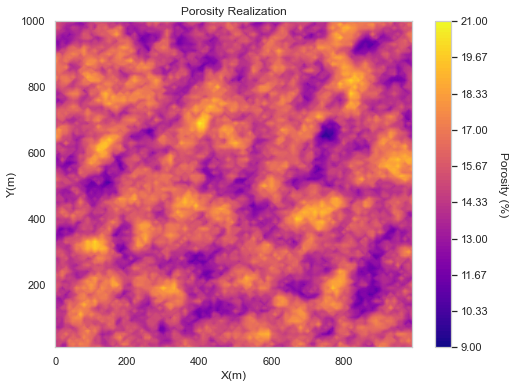

In [13]:
plt.figure(figsize=(10, 8));
cmap = plt.cm.plasma
GSLIB.pixelplt(sim, xmin, xmax, ymin, ymax, cell_size, np.floor(np.min(sim)), np.ceil(np.max(sim)),
               "Porosity Realization", "X(m)", "Y(m)", "Porosity (%)",cmap, 'Porosity_Simulation');

**Trend**

To impose a trend, use a multivariable function. Then add the known function (trend) to the previous simulation.

<Figure size 720x576 with 0 Axes>

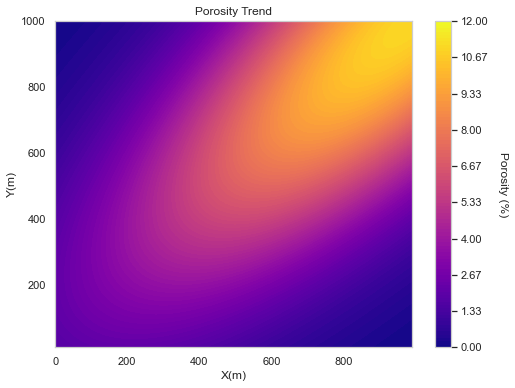

In [14]:
x = np.linspace(2,6, 100)
xx, yy = np.meshgrid(x, x) # create a meshgrid to simplify the addition of coordinate 
trend =  150 * np.flipud(multi_gaussian(rho=.8, mean1=6, mean2=6, std1=2.2, std2=2.2, x1=xx, x2=yy))

# Plot
plt.figure(figsize=(10, 8))
cmap = plt.cm.plasma
GSLIB.pixelplt(trend, xmin, xmax, ymin, ymax, cell_size, np.floor(np.min(trend)), np.ceil(np.max(trend)),
               "Porosity Trend", "X(m)", "Y(m)", "Porosity (%)",cmap, 'Porosity_trend')
plt.show()

Plot the combined model: trend + model

<Figure size 720x576 with 0 Axes>

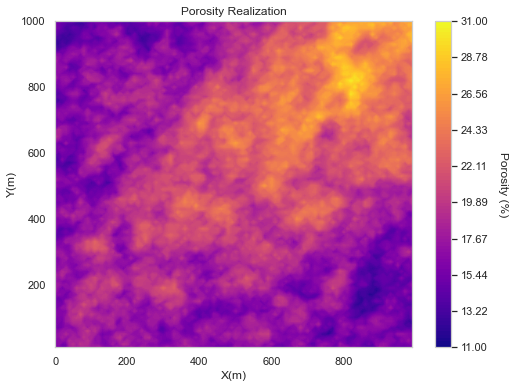

In [15]:
combined_model = trend + sim

plt.figure(figsize=(10, 8));
GSLIB.pixelplt(combined_model, xmin, xmax, ymin, ymax, cell_size, np.floor(np.min(combined_model)), np.ceil(np.max(combined_model)),
               "Porosity Realization", "X(m)", "Y(m)", "Porosity (%)",cmap, 'Porosity_comb');

## Geological trend confirmation

To confirm the presence of a trend in our combined model, let's plot the variogram in the direction of major continuity: 0. To do so, we use `geostats.gam` because we have data points at each grid node. The coordinates `ixd, iyd` should be the following:

* Azimuth = 00; `ixd=0`, `iyd=1`
* Azimuth = 45; `ixd=1`, `iyd=1`
* Azimuth = 90; `ixd=1`, `iyd=0`

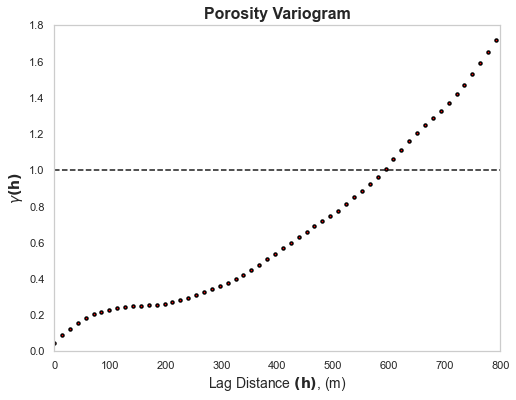

In [16]:
lag_phi, vario_phi, npar_phi = geostats.gam(combined_model,tmin = \
                            -999, tmax = 999, xsiz = 10.0, ysiz = 10.0, ixd = 1, iyd = -1, nlag = 80, isill = 1.0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(lag_phi,vario_phi,'o', markerfacecolor='red',markeredgecolor='black',markersize=3.0,markeredgewidth=1.5)
ax.plot([0,2000],[1.0,1.0], 'k--')
ax.set_xlabel(r'Lag Distance $\bf(h)$, (m)', fontsize=14)
ax.set_ylabel(r'$\gamma \bf(h)$', fontsize=14)
ax.set_title('Porosity Variogram', fontsize=16, fontweight='bold')
ax.set_xlim([0,800])
ax.set_ylim([0,1.8])
plt.show()

Bingo! the variogram shows a trend in 45 azimuth, as expected.

## Example of nonstationary porosity realizations

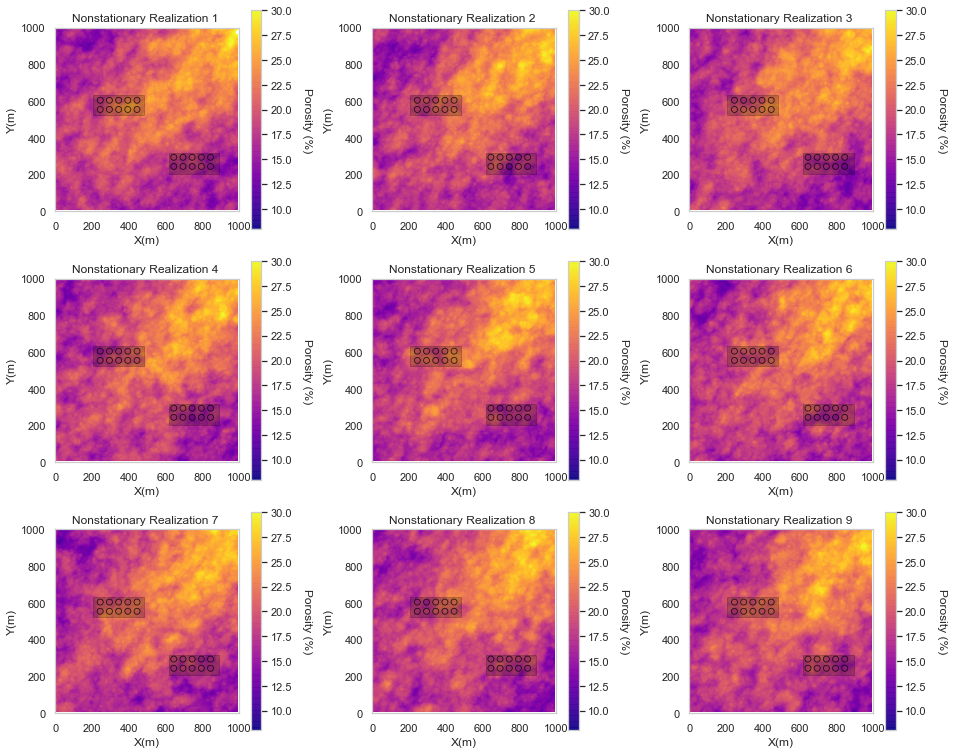

In [17]:
for real_i in range(9):
    plt.subplot(3,3,real_i+1,aspect="equal")
    
    # This is the example realization with pads for the above Figure
    # Pad 1
    ox = 20; oy = 51 # origin of pad times (x10m) (bottom left corner)
    nxwell = 5; nywell = 2 # number of wells in x and y
    xspace = 50; yspace = 50 # space in x and y between wells
    tempo = realizations[real_i, :, :]+trend
    pad1i = extract_pad_sample(tempo, xmin, xmax, ymin, ymax, cell_size, ox=ox, oy=oy, xspace=xspace, yspace=yspace,
                              nxwell=nxwell, nywell=nywell, name='Porosity')
    # Pad 2
    ox2 = 60; oy2 = 20 # origin of pad (bottom left corner)
    nxwell2 = 5; nywell2 = 2 # number of wells in x and y
    xspace2 = 50; yspace2 = 50 # space in x and y between wells
    pad2i = extract_pad_sample(tempo, xmin, xmax, ymin, ymax, cell_size, ox=ox2, oy=oy2, xspace=xspace2, yspace=yspace2,
                              nxwell=nxwell2, nywell=nywell2, name='Porosity')

    padi = pd.concat([pad1i,pad2i],axis=0)

    GSLIB.locpix_st(tempo,xmin,xmax,ymin,ymax,cell_size,8,30,padi,'X','Y',
                    'Porosity',"Nonstationary Realization {0:2s}".format(str(real_i+1)),'X(m)','Y(m)','Porosity (%)',cmap)
    plt.gca().add_patch(Rectangle((ox*10*1.03, oy*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1, color='black',
                              linewidth = 1.0,alpha=0.2,facecolor = None))
    plt.gca().add_patch(Rectangle((ox2*10*1.03, oy2*10*1.03), width=xspace2*nxwell2*1.1, height=yspace2*nywell2*1.1, color='black',
                                  linewidth = 1.0,alpha=0.2,facecolor = None))
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.38, hspace=0.15)
plt.show()

## Sampling from well pads 1, 2, and 3.

We will sample from our combined model (the one that has a trend) using four well pads (although the 4th is not used), each one with 10 wells spaced 50 meters in X and Y.

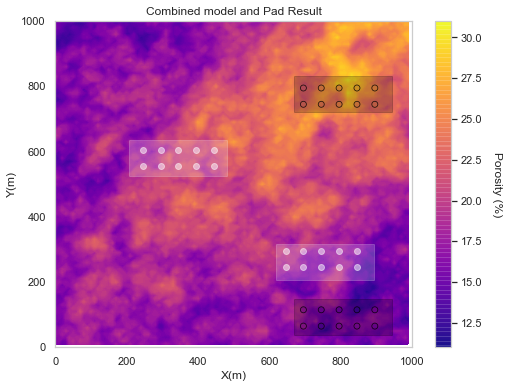

In [18]:
# This is the example realization with pads for the above Figure
# Pad 1
ox3 = 65; oy3 = 70 # origin of pad times (x10m) (bottom left corner)
nxwell = 5; nywell = 2 # number of wells in x and y
xspace = 50; yspace = 50 # space in x and y between wells
pad3 = extract_pad_sample(combined_model, xmin, xmax, ymin, ymax, cell_size, ox=ox3, oy=oy3,
                          xspace=xspace, yspace=yspace,
                          nxwell=nxwell, nywell=nywell, name='Porosity')
# Pad 2
ox4 = 65; oy4 = 2 # origin of pad (bottom left corner)
nxwell2 = 5; nywell2 = 2 # number of wells in x and y
xspace2 = 50; yspace2 = 50 # space in x and y between wells
pad4 = extract_pad_sample(combined_model, xmin, xmax, ymin, ymax, cell_size, ox=ox4, oy=oy4,
                          xspace=xspace2, yspace=yspace2,
                          nxwell=nxwell2, nywell=nywell2, name='Porosity')

pad34 = pd.concat([pad3,pad4],axis=0)

plt.figure(figsize=(8, 6))
cmap = plt.cm.plasma

GSLIB.locpix_st(combined_model, xmin, xmax, ymin, ymax, cell_size, np.floor(np.min(combined_model)),
                np.ceil(np.max(combined_model)), pad34,
                'X','Y','Porosity','Combined model and Pad Result', 'X(m)', 'Y(m)','Porosity (%)',cmap)
plt.gca().add_patch(Rectangle((ox3*10*1.03, oy3*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1,
                              color='black',
                              linewidth = 1.0,alpha=0.2,facecolor = None))
plt.gca().add_patch(Rectangle((ox4*10*1.03, oy4*10*1.9), width=xspace2*nxwell2*1.1, height=yspace2*nywell2*1.1,
                              color='black',
                              linewidth = 1.0,alpha=0.2,facecolor = None))

# Add the code below just to represent other well pads in white. DO NOT FORGET TO recompute the original well pads

# This is the example realization with pads for the above Figure
# Pad 1
ox1 = 20; oy1 = 51 # origin of pad times (x10m) (bottom left corner)
nxwell = 5; nywell = 2 # number of wells in x and y
xspace = 50; yspace = 50 # space in x and y between wells
pad1 = extract_pad_sample(combined_model, xmin, xmax, ymin, ymax, cell_size, ox=ox1, oy=oy1, xspace=xspace, yspace=yspace,
                          nxwell=nxwell, nywell=nywell, name='Porosity')
# Pad 2
ox2 = 60; oy2 = 20 # origin of pad (bottom left corner)
nxwell2 = 5; nywell2 = 2 # number of wells in x and y
xspace2 = 50; yspace2 = 50 # space in x and y between wells
pad2 = extract_pad_sample(combined_model, xmin, xmax, ymin, ymax, cell_size, ox=ox2, oy=oy2, xspace=xspace2, yspace=yspace2,
                          nxwell=nxwell2, nywell=nywell2, name='Porosity')

pad12 = pd.concat([pad1,pad2],axis=0)

plt.plot(pad12['X'], pad12['Y'], 'wo', alpha=0.5)
plt.gca().add_patch(Rectangle((ox1*10*1.03, oy1*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1,
                              color='white',
                              linewidth = 1.0,alpha=0.2,facecolor = None))
plt.gca().add_patch(Rectangle((ox2*10*1.03, oy2*10*1.03), width=xspace2*nxwell2*1.1, height=yspace2*nywell2*1.1,
                              color='white',
                              linewidth = 1.0,alpha=0.2,facecolor = None))

plt.show()

pad13 = pd.concat([pad1,pad3],axis=0)

Again, store the values in `DataFrames` for the well pads.

In [19]:
index1 = []; index2 = []
for phi in np.arange(0, len(pad1)):
    index1.append(np.where(combined_model.ravel() == pad1.iloc[phi,2])[0][0])
    index2.append(np.where(combined_model.ravel() == pad2.iloc[phi,2])[0][0])

pad1.index = index1
pad2.index = index2

pad1['Trend'] = trend.ravel()[pad1.index.values]
pad2['Trend'] = trend.ravel()[pad2.index.values]

index1 = []; index2 = []
for phi in np.arange(0, len(pad3)):
    index1.append(np.where(combined_model.ravel() == pad3.iloc[phi,2])[0][0])
    index2.append(np.where(combined_model.ravel() == pad4.iloc[phi,2])[0][0])

pad3.index = index1
pad4.index = index2

pad3['Trend'] = trend.ravel()[pad3.index.values]
pad4['Trend'] = trend.ravel()[pad4.index.values]

Perform spatial bootstrap and add the trend at the well locations from well pads 1 and 2.

In [41]:
num_sim = 10 # number of sim_is

# create the DataFrame that will store all results
sampling_dist_pad12 = pd.DataFrame(np.zeros((num_sim, 3)), columns=['N1 Mean', 'N2 Mean', 'Difference Means'])

means_diff = np.zeros((num_sim, 1)) # initialize the array where you will store the difference of means
n_eff = np.zeros_like(means_diff) # initialize the array where you will store the average n effective

for sim_i in range(0, num_sim):
    sim = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed+sim_i, vario, 'sim_i')
    sim = GSLIB.affine(array=sim, tmean=15, tstdev=1.5) # correct the distribution to a target mean and standard deviation
    
    ############################################################
    ## Compute the means of the data sampling sets
    ############################################################
    mean1 = np.mean(sim.ravel()[pad1.index.values] + pad1['Trend'])# add the porosity values from the trend back at data locations
    mean2 = np.mean(sim.ravel()[pad2.index.values] + pad2['Trend'])# add the porosity values from the trend back at data locations
    sampling_dist_pad12.iloc[sim_i, 0] = mean1
    sampling_dist_pad12.iloc[sim_i, 1] = mean2

# ############################################################
# ## Final computations
# ############################################################
sampling_dist_pad12['Difference Means'] = sampling_dist_pad12['N2 Mean'] - sampling_dist_pad12['N1 Mean'] # compute difference of the means

Perform spatial bootstrap and add the trend at the well locations from well pads 1 and 3.

In [42]:
num_sim = 10 # number of sim_is

# create the DataFrame that will store all results
sampling_dist_pad13 = pd.DataFrame(np.zeros((num_sim, 3)), columns=['N1 Mean', 'N2 Mean', 'Difference Means'])

means_diff = np.zeros((num_sim, 1)) # initialize the array where you will store the difference of means
n_eff = np.zeros_like(means_diff) # initialize the array where you will store the average n effective

for sim_i in range(0, num_sim):
    sim = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed+sim_i, vario, 'sim_i')
    sim = GSLIB.affine(array=sim, tmean=15, tstdev=1.5) # correct the distribution to a target mean and standard deviation
    
    ############################################################
    ## Compute the means of the data sampling sets
    ############################################################
    mean1 = np.mean(sim.ravel()[pad1.index.values] + pad1['Trend'])# add the porosity values from the trend back at data locations
    mean2 = np.mean(sim.ravel()[pad3.index.values] + pad3['Trend'])# add the porosity values from the trend back at data locations
    sampling_dist_pad13.iloc[sim_i, 0] = mean1
    sampling_dist_pad13.iloc[sim_i, 1] = mean2

# ############################################################
# ## Final computations
# ############################################################
sampling_dist_pad13['Difference Means'] = sampling_dist_pad13['N2 Mean'] - sampling_dist_pad13['N1 Mean'] # compute difference of the means

Read the pickle file that has 10,000 realizations.

In [20]:
sampling_dist_pad12 = pd.read_pickle('./Demonstration2_pad12.pkl')
sampling_dist_pad12['Difference Means'] = sampling_dist_pad12['N2 Mean'] - sampling_dist_pad12['N1 Mean']

sampling_dist_pad13 = pd.read_pickle('./Demonstration2_pad13.pkl')
sampling_dist_pad13['Difference Means'] = sampling_dist_pad13['N2 Mean'] - sampling_dist_pad13['N1 Mean']

## Estimation plots

### Well pads 1 and 2

Let's visualize the estimation plot

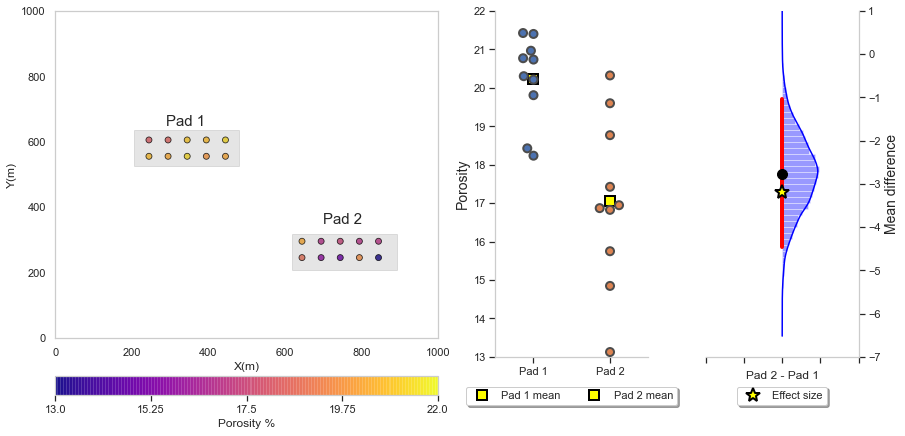

In [29]:
modified_GA(pad1, pad2, 'Porosity', pad12, 'X', 'Y', sampling_dist_pad12, simulation=sim,
          case=2, pad1_swarmnumber=1, pad2_swarmnumber=2)

Because of the trend the mean difference between the well pads does not include zero. The difference of means distribution is:

In [30]:
############################################################
## Critical values (empirical)
############################################################
per_up_05 = sampling_dist_pad12['Difference Means'].quantile(q=0.975)
per_down_05 = sampling_dist_pad12['Difference Means'].quantile(q=0.025)

print('{0:5^s}'.format('CONFIDENCE INTERVAL'))
print('The 95% CI: {0:0.2f} < \u03BC1-\u03BC2 < {1:0.2f}'.format(per_down_05, per_up_05))

CONFIDENCE INTERVAL
The 95% CI: -4.46 < μ1-μ2 < -1.03


In [31]:
############################################################
## Insert observed difference
############################################################
observed_diff = pad2['Porosity'].mean() - pad1['Porosity'].mean()

############################################################
## Final computations
############################################################
# obtain the length of the DataFrame, i.e. number of rows
length = len(sampling_dist_pad12['Difference Means'])
# compute the corresponding percentile of the value entered for the other tail (left or right)
other_diff = 100 - scipy.stats.percentileofscore(a=sampling_dist_pad12['Difference Means'], score=observed_diff)
# obtain the value corresponding to the above percentile (left or right)
other_diff = np.percentile(sampling_dist_pad12['Difference Means'], other_diff)
denominator = length + 1

if other_diff < observed_diff: # observed difference is on the right
    larger_than_right = sum(sampling_dist_pad12['Difference Means'] > observed_diff)
    smaller_than_left = sum(sampling_dist_pad12['Difference Means'] < other_diff)
    pval = (larger_than_right + smaller_than_left + 1 + 1) / denominator
else:
    larger_than_right = sum(sampling_dist_pad12['Difference Means'] > other_diff)
    smaller_than_left = sum(sampling_dist_pad12['Difference Means'] < observed_diff)
    pval = (larger_than_right + smaller_than_left + 1 + 1) / denominator

BFB = (-1)/(np.e * pval * np.log(pval))
Pr = BFB / (1 + BFB)

print('Observed difference: {0:0.2f}'.format(observed_diff))
print('Empirical p-value: {0:0.2%}'.format(pval))
print('Bayes factor bound: {0:0.2f}'.format(BFB))
print('There is at maximum a {0:0.2%} chance the alternative hypothesis is true'.format(Pr))

Observed difference: -3.18
Empirical p-value: 63.21%
Bayes factor bound: 1.27
There is at maximum a 55.92% chance the alternative hypothesis is true


### Well pads 1 and 3
Next, we modify the spatial correlation in well pad 3 to force the model to say there is geostatistical significance.

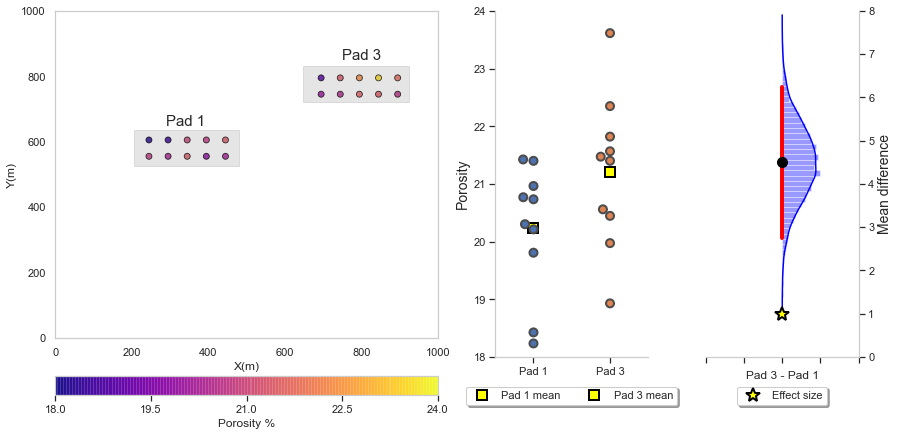

In [21]:
pad3a = pad3.copy()
pad3a['Porosity'] *= .85 # Modify the spatial correlation
pad13 = pd.concat([pad1,pad3a],axis=0)

modified_GA(pad1, pad3a, 'Porosity', pad13, 'X', 'Y', sampling_dist_pad13, simulation=sim,
          case=3, pad1_swarmnumber=1, pad2_swarmnumber=3)

In [20]:
fig.savefig('Fig5.tiff', dpi=150, format="tiff", bbox_inches='tight')

In [33]:
############################################################
## Critical values (empirical)
############################################################
per_up_05 = sampling_dist_pad13['Difference Means'].quantile(q=0.975)
per_down_05 = sampling_dist_pad13['Difference Means'].quantile(q=0.025)

print('{0:5^s}'.format('CONFIDENCE INTERVAL'))
print('The 95% CI: {0:0.2f} < \u03BC1-\u03BC2 < {1:0.2f}'.format(per_down_05, per_up_05))

CONFIDENCE INTERVAL
The 95% CI: 2.75 < μ1-μ2 < 6.23


In [34]:
############################################################
## Insert observed difference
############################################################
observed_diff = pad3a['Porosity'].mean() - pad1['Porosity'].mean()

############################################################
## Final computations
############################################################
# obtain the length of the DataFrame, i.e. number of rows
length = len(sampling_dist_pad13['Difference Means'])
# compute the corresponding percentile of the value entered for the other tail (left or right)
other_diff = 100 - scipy.stats.percentileofscore(a=sampling_dist_pad13['Difference Means'], score=observed_diff)
# obtain the value corresponding to the above percentile (left or right)
other_diff = np.percentile(sampling_dist_pad13['Difference Means'], other_diff)
denominator = length + 1

if other_diff < observed_diff: # observed difference is on the right
    larger_than_right = sum(sampling_dist_pad13['Difference Means'] > observed_diff)
    smaller_than_left = sum(sampling_dist_pad13['Difference Means'] < other_diff)
    pval = (larger_than_right + smaller_than_left + 1 + 1) / denominator
else:
    larger_than_right = sum(sampling_dist_pad13['Difference Means'] > other_diff)
    smaller_than_left = sum(sampling_dist_pad13['Difference Means'] < observed_diff)
    pval = (larger_than_right + smaller_than_left + 1 + 1) / denominator

BFB = (-1)/(np.e * pval * np.log(pval))
Pr = BFB / (1 + BFB)

print('Observed difference: {0:0.2f}'.format(observed_diff))
print('Empirical p-value: {0:0.2%}'.format(pval))
print('Bayes factor bound: {0:0.2f}'.format(BFB))
print('There is at maximum a {0:0.2%} chance the alternative hypothesis is true'.format(Pr))

Observed difference: 0.99
Empirical p-value: 0.02%
Bayes factor bound: 215.98
There is at maximum a 99.54% chance the alternative hypothesis is true


# Demonstration III: Geostatistical significance to assess difference in the presence of conditioning data

## Well pads are located in locations as in case 3.1

We will add some wells outside the pads. These wells will have porosity data, which will impart spatial conditioning to the well pads.

First, create the true model (stationary)

<Figure size 720x576 with 0 Axes>

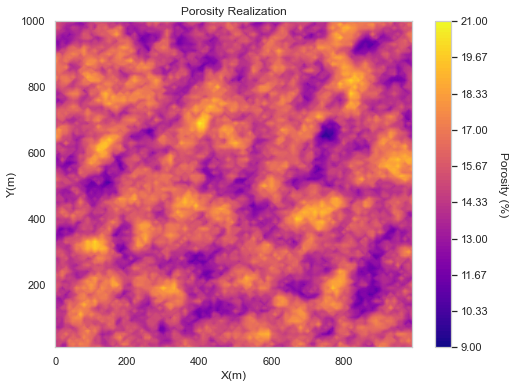

In [35]:
vario = GSLIB.make_variogram(nug=0, nst=1, it1=1, cc1=1.0, azi1=azimuth, hmaj1=90, hmin1=70)
sim = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed, vario, 'simulation')

sim = GSLIB.affine(sim, mean, stdev)              # correct the distribution to a target mean and standard deviation.

plt.figure(figsize=(10, 8));
cmap = plt.cm.plasma
GSLIB.pixelplt(sim, xmin, xmax, ymin, ymax, cell_size, np.floor(np.min(sim)), np.ceil(np.max(sim)),
               "Porosity Realization", "X(m)", "Y(m)", "Porosity (%)",cmap, 'Porosity_Simulation');

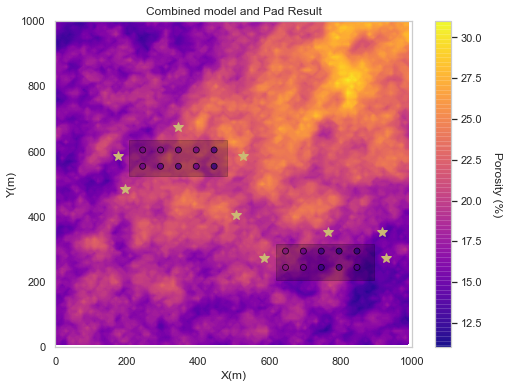

In [36]:
# add the trend and stationary to have a non stationary model. This is your true model
combined_model = sim + trend

########################################################################
# Well pads
########################################################################
# Pad 1
ox = 20; oy = 51 # origin of pad times (x10m) (bottom left corner)
nxwell = 5; nywell = 2 # number of wells in x and y
xspace = 50; yspace = 50 # space in x and y between wells
pad1 = extract_pad_sample(combined_model, xmin, xmax, ymin, ymax, cell_size, ox=ox, oy=oy, xspace=xspace, yspace=yspace,
                          nxwell=nxwell, nywell=nywell, name='Porosity')
# Pad 2
ox2 = 60; oy2 = 20 # origin of pad (bottom left corner)
nxwell2 = 5; nywell2 = 2 # number of wells in x and y
xspace2 = 50; yspace2 = 50 # space in x and y between wells
pad2 = extract_pad_sample(combined_model, xmin, xmax, ymin, ymax, cell_size, ox=ox2, oy=oy2, xspace=xspace2, yspace=yspace2,
                          nxwell=nxwell2, nywell=nywell2, name='Porosity')

pad12 = pd.concat([pad1,pad2],axis=0)

########################################################################
# Extra wells outside the pads
########################################################################
wells = [925, 275, 585, 275, 175, 585, 525, 585, 915, 355, 195, 485, 765, 355, 345, 675, 505, 405]

# Transform the previous list into a DataFrame
wells_df = pd.DataFrame(np.zeros((int(len(wells)/2), 3)), columns=['X', 'Y', 'Porosity'])
for i in np.arange(0, int(len(wells)), 2):
    wells_df.iloc[int(i/2), 0] = wells[i]
    wells_df.iloc[int(i/2), 1] = wells[i+1]

for i in range(len(wells_df)):
    wells_df.iloc[i, 2] = combined_model[int(100-np.floor(wells_df.iloc[i, 1])/10), int(np.ceil(wells_df.iloc[i, 0]/10))]
    
########################################################################
# Update the indexes in the data frames
########################################################################
index1 = []; index2 = []; index3 = []
for phi in np.arange(0, len(pad1)):
    index1.append(np.where(combined_model.ravel() == pad1.iloc[phi,2])[0][0])
    index2.append(np.where(combined_model.ravel() == pad2.iloc[phi,2])[0][0])
for phi in np.arange(0, len(wells_df)):
    index3.append(np.where(combined_model.ravel() == wells_df.iloc[phi,2])[0][0])

pad1.index = index1
pad2.index = index2
wells_df.index = index3
    
########################################################################
# Plotting
########################################################################
plt.figure(figsize=(8, 6))
cmap = plt.cm.plasma

GSLIB.locpix_st(combined_model, xmin, xmax, ymin, ymax, cell_size, np.floor(np.min(combined_model)),
                np.ceil(np.max(combined_model)), pad,'X','Y','Porosity','Combined model and Pad Result', 'X(m)',
                'Y(m)','Porosity (%)',cmap)
plt.gca().add_patch(Rectangle((ox*10*1.03, oy*10*1.03), width=xspace*nxwell*1.1, height=yspace*nywell*1.1, color='black',
                              linewidth = 1.0,alpha=0.2,facecolor = None))
plt.gca().add_patch(Rectangle((ox2*10*1.03, oy2*10*1.03), width=xspace2*nxwell2*1.1, height=yspace2*nywell2*1.1, color='black',
                              linewidth = 1.0,alpha=0.2,facecolor = None))
for i in np.arange(0, int(len(wells)), 2):
    plt.plot(wells[i], wells[i+1], 'y*', markersize=10)

plt.show()

The conditional method requires the data in normal scores. Convert the porosity values from the existing wells (yellow stars) to normal scores.

In [37]:
wells_df['Porosity Ns'], tv, tns = geostats.nscore(df=wells_df, vcol='Porosity')

Add the trend porosity to the well pads.

In [38]:
pad1['Trend'] = trend.ravel()[pad1.index.values]
pad2['Trend'] = trend.ravel()[pad2.index.values]

In [39]:
pad1

X      Y   Porosity     Trend
4525  245.0  555.0  20.768171  3.985253
4530  295.0  555.0  20.301398  4.706308
4535  345.0  555.0  21.423798  5.429156
4540  395.0  555.0  19.806669  6.118034
4545  445.0  555.0  20.211593  6.734711
4025  245.0  605.0  18.233437  3.685359
4030  295.0  605.0  18.424779  4.434476
4035  345.0  605.0  20.963300  5.212334
4040  395.0  605.0  20.733050  5.984802
4045  445.0  605.0  21.399576  6.712663

Perform spatial bootstrap. In this case, we add the trend values at the well locations in each realization to account for non stationarities. Moreover, this is a conditional simulation, i.e. the porosity from the nine wells will be kept constant through all the iterations.

In [40]:
num_sim = 10 # number of sim_is

# create the DataFrame that will store all results
sampling_dist = pd.DataFrame(np.zeros((num_sim, 3)), columns=['N1 Mean', 'N2 Mean', 'Difference Means'])

means_diff = np.zeros((num_sim, 1)) # initialize the array where you will store the difference of means
n_eff = np.zeros_like(means_diff) # initialize the array where you will store the average n effective

for sim_i in range(0, num_sim):
    sim = GSLIB.sgsim(nreal=1, df=wells_df, xcol='X', ycol='Y', vcol='Porosity Ns', nx=nx, ny=ny, hsiz=cell_size, seed=sim_i,
            var=vario, output_file='sim_i')

    sim = np.interp(sim,tns,tv) # transform back to original porosity units
    
    ############################################################
    ## Compute the means of the data sampling sets
    ############################################################
    mean1 = np.mean(sim.ravel()[pad1.index.values] + pad1['Trend'])# add the porosity values from the trend back at data locations
    mean2 = np.mean(sim.ravel()[pad2.index.values] + pad2['Trend'])# add the porosity values from the trend back at data locations
    sampling_dist.iloc[sim_i, 0] = mean1
    sampling_dist.iloc[sim_i, 1] = mean2

############################################################
## Final computations
############################################################
sampling_dist['Difference Means'] = sampling_dist['N2 Mean'] - sampling_dist['N1 Mean'] # compute difference of the means

Store the realizations in a pickle archive.

In [41]:
sampling_dist = pd.read_pickle("./Demonstration3.pkl")
sampling_dist['Difference Means'] = sampling_dist['N2 Mean'] - sampling_dist['N1 Mean']

In [42]:
sampling_dist.describe()

N1 Mean      N2 Mean  Difference Means
count  9999.000000  9999.000000       9999.000000
mean     24.103591    21.309223         -2.794367
std       1.112806     1.106176          1.567529
min      19.742113    16.975787         -8.745408
25%      23.341646    20.553112         -3.850332
50%      24.135195    21.339329         -2.799434
75%      24.889431    22.080191         -1.746947
max      27.537379    24.742813          2.986169

## Estimation plots
Let's plot the modified Gardner-Altamn plot for demonstration 3.

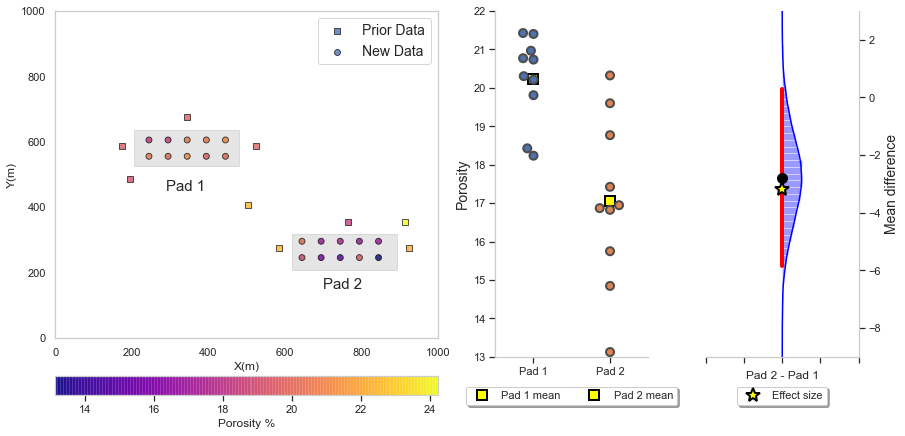

In [43]:
modified_GA(pad1, pad2, 'Porosity', pad12, 'X', 'Y', sampling_dist, simulation=combined_model,
          case=4, pad1_swarmnumber=1, pad2_swarmnumber=2)

## Critical statistics

In [44]:
############################################################
## Critical values (empirical)
############################################################
per_up_05 = sampling_dist['Difference Means'].quantile(q=0.975)
per_down_05 = sampling_dist['Difference Means'].quantile(q=0.025)

print('{0:5^s}'.format('CONFIDENCE INTERVAL'))
print('The 95% CI: {0:0.2f} < \u03BC1-\u03BC2 < {1:0.2f}'.format(per_down_05, per_up_05))

CONFIDENCE INTERVAL
The 95% CI: -5.84 < μ1-μ2 < 0.30


In [45]:
############################################################
## Insert observed difference
############################################################
observed_diff = pad2['Porosity'].mean() - pad1['Porosity'].mean()

############################################################
## Final computations
############################################################
# obtain the length of the DataFrame, i.e. number of rows
length = len(sampling_dist['Difference Means'])
# compute the corresponding percentile of the value entered for the other tail (left or right)
other_diff = 100 - scipy.stats.percentileofscore(a=sampling_dist['Difference Means'], score=observed_diff)
# obtain the value corresponding to the above percentile (left or right)
other_diff = np.percentile(sampling_dist['Difference Means'], other_diff)
denominator = length + 1

if other_diff < observed_diff: # observed difference is on the right
    larger_than_right = sum(sampling_dist['Difference Means'] > observed_diff)
    smaller_than_left = sum(sampling_dist['Difference Means'] < other_diff)
    pval = (larger_than_right + smaller_than_left + 1 + 1) / denominator
else:
    larger_than_right = sum(sampling_dist['Difference Means'] > other_diff)
    smaller_than_left = sum(sampling_dist['Difference Means'] < observed_diff)
    pval = (larger_than_right + smaller_than_left + 1 + 1) / denominator

BFB = (-1)/(np.e * pval * np.log(pval))
Pr = BFB / (1 + BFB)

print('Observed difference: {0:0.2f}'.format(observed_diff))
print('Empirical p-value: {0:0.2%}'.format(pval))
print('Bayes factor bound: {0:0.2f}'.format(BFB))
print('There is at maximum a {0:0.2%} chance the alternative hypothesis is true'.format(Pr))

Observed difference: -3.18
Empirical p-value: 80.48%
Bayes factor bound: 2.10
There is at maximum a 67.79% chance the alternative hypothesis is true


# Further aplications: Checking trend models

We will assign two well pads and gradually increase the influence of the trend using the following equation:

$z({\boldsymbol{U_\alpha{}}}) = z_s + (z_t - \bar{z_t}) * k +  \bar{z_t}$

$0 \leq \text{k} \leq1$

where $z({\boldsymbol{U_\alpha{}}})$ is the final feature model, $z_s$ is a stationary feature model, $z_t$ is a trend model, and $\overline{z_t}$ is the global mean of $z_t$. The parameter _k_ is a number that varies from 0 to 1, which specifies the strength of the trend in the final model

In [6]:
# Modeling parameters, the model grid, the random seed, the target distribution, and color bar
nx = 100; ny = 100; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0                                           # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model
seed = 43                                                        # random number seed  for stochastic simulation   
range_max = 100; range_min = 10; azimuth = 45                    # Porosity variogram ranges and azimuth
mean = 15.; stdev = 1.5                                         # Porosity mean and standard deviation
cmap = plt.cm.inferno                                            # using the plasma color map

Generate the first simulation and plot it. Recall that it does not have a  trend.

In [7]:
vario = GSLIB.make_variogram(nug=0, nst=1, it1=1, cc1=1.0, azi1=azimuth, hmaj1=90, hmin1=70)
z_s = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed, vario, 'simulation')

z_s = GSLIB.affine(z_s, mean, stdev)              # correct the distribution to a target mean and standard deviation.

<Figure size 720x576 with 0 Axes>

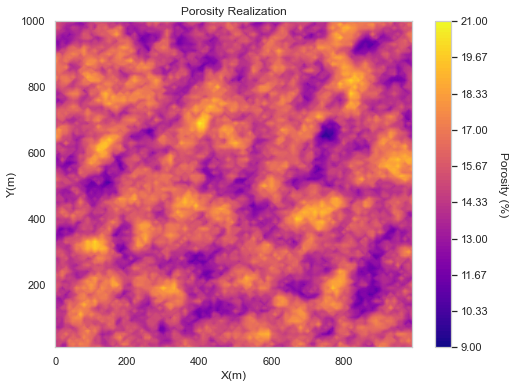

In [8]:
plt.figure(figsize=(10, 8));
cmap = plt.cm.plasma
GSLIB.pixelplt(z_s, xmin, xmax, ymin, ymax, cell_size, np.floor(np.min(z_s)), np.ceil(np.max(z_s)),
               "Porosity Realization", "X(m)", "Y(m)", "Porosity (%)",cmap, 'Porosity_z_sulation');

**Trend**

To impose a trend, use a multivariable function. Then add the known function (trend) to the previous simulation.

<Figure size 720x576 with 0 Axes>

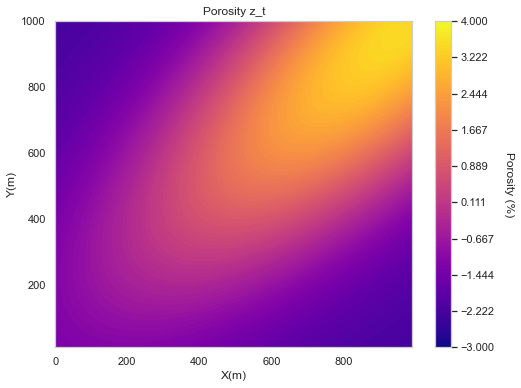

In [9]:
x = np.linspace(2,6, 100)
xx, yy = np.meshgrid(x, x) # create a meshgrid to simplify the addition of coordinate 
z_t =  150 * np.flipud(multi_gaussian(rho=.8, mean1=6, mean2=6, std1=2.2, std2=2.2, x1=xx, x2=yy))
# affine correction such the mean = 0
z_t = GSLIB.affine(z_t, tmean=0, tstdev=1.5)

# Plot
plt.figure(figsize=(10, 8))
cmap = plt.cm.plasma
GSLIB.pixelplt(z_t, xmin, xmax, ymin, ymax, cell_size, np.floor(np.min(z_t)), np.ceil(np.max(z_t)),
               "Porosity z_t", "X(m)", "Y(m)", "Porosity (%)",cmap, 'Porosity_z_t')
plt.show()

Plot the combined model: trend + model

<Figure size 720x576 with 0 Axes>

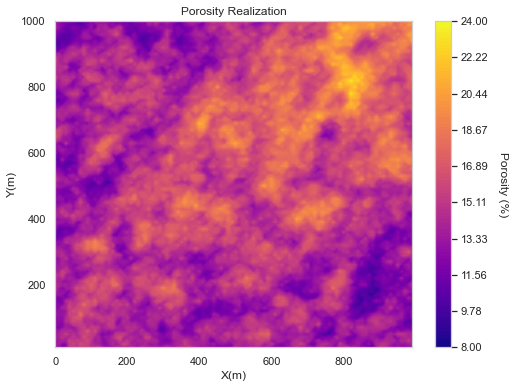

In [10]:
combined_model = z_s + z_t

plt.figure(figsize=(10, 8));
GSLIB.pixelplt(combined_model, xmin, xmax, ymin, ymax, cell_size, np.floor(np.min(combined_model)), np.ceil(np.max(combined_model)),
               "Porosity Realization", "X(m)", "Y(m)", "Porosity (%)",cmap, 'Porosity_comb');

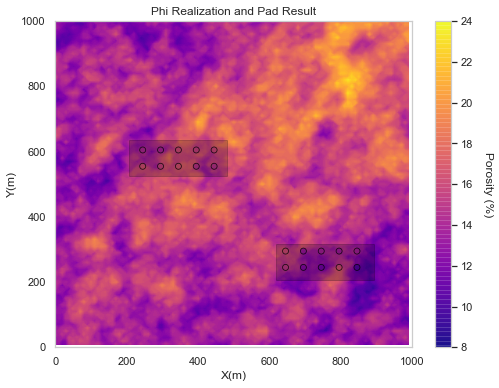

In [11]:
# This is the example realization with pads for the above Figure
# Pad 1
ox = 20; oy = 51 # origin of pad times (x10m) (bottom left corner)
nxwell = 5; nywell = 2 # number of wells in x and y
xspace = 50; yspace = 50 # space in x and y between wells
pad1 = extract_pad_sample(combined_model, xmin, xmax, ymin, ymax,
                          cell_size, ox=ox, oy=oy, xspace=xspace,
                          yspace=yspace,nxwell=nxwell, nywell=nywell,
                          name='Porosity')
# Pad 2
ox2 = 60; oy2 = 20 # origin of pad (bottom left corner)
nxwell2 = 5; nywell2 = 2 # number of wells in x and y
xspace2 = 50; yspace2 = 50 # space in x and y between wells
pad2 = extract_pad_sample(combined_model, xmin, xmax, ymin, ymax, cell_size,
                          ox=ox2, oy=oy2, xspace=xspace2, yspace=yspace2,
                          nxwell=nxwell2, nywell=nywell2, name='Porosity')

pad = pd.concat([pad1,pad2],axis=0)

plt.figure(figsize=(8, 6))
GSLIB.locpix_st(combined_model, xmin, xmax, ymin, ymax, cell_size,
                np.floor(np.min(combined_model)),
                np.ceil(np.max(combined_model)), pad,
                'X','Y','Porosity','Phi Realization and Pad Result',
                'X(m)', 'Y(m)','Porosity (%)',cmap)

plt.gca().add_patch(Rectangle((ox*10*1.03, oy*10*1.03),
                              width=xspace*nxwell*1.1,
                              height=yspace*nywell*1.1, color='black',
                              linewidth = 1.0,alpha=0.2,facecolor = None))
plt.gca().add_patch(Rectangle((ox2*10*1.03, oy2*10*1.03),
                              width=xspace2*nxwell2*1.1,
                              height=yspace2*nywell2*1.1, color='black',
                              linewidth = 1.0,alpha=0.2,facecolor = None))

plt.show()

In [12]:
index1 = []; index2 = []
for phi in np.arange(0, len(pad1)):
    index1.append(np.where(combined_model.ravel() == pad1.iloc[phi,2])[0][0])
    index2.append(np.where(combined_model.ravel() == pad2.iloc[phi,2])[0][0])

pad1.index = index1
pad2.index = index2

pad1['Trend'] = z_t.ravel()[pad1.index.values]
pad2['Trend'] = z_t.ravel()[pad2.index.values]

In [13]:
# num_sim = 10000 # number of sim_is

# # create the DataFrame that will store all results
# sampling_dist = pd.DataFrame(np.zeros((num_sim, 3)),
#                              columns=['N1 Mean', 'N2 Mean', 'Difference Means'])

# # initialize the array where you will store the difference of means
# means_diff = np.zeros((num_sim, 1))
# # initialize the array where you will store the average n effective
# n_eff = np.zeros_like(means_diff)

# for sim_i in range(0, num_sim):
#     sim = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed+sim_i, vario, 'sim_i')
    
#     # correct the distribution to a target mean and standard deviation
#     sim = GSLIB.affine(array=sim, tmean=15., tstdev=1.5)
    
#     ############################################################
#     ## Compute the means of the data sampling sets
#     ############################################################
#     # add the porosity values from the trend back at data locations
#     mean1 = np.mean(sim.ravel()[pad1.index.values] + pad1['Trend'])
#     mean2 = np.mean(sim.ravel()[pad2.index.values] + pad2['Trend'])
#     sampling_dist.iloc[sim_i, 0] = mean1
#     sampling_dist.iloc[sim_i, 1] = mean2

# # ############################################################
# # ## Final computations
# # ############################################################
# sampling_dist['Difference Means'] = sampling_dist['N2 Mean'] - sampling_dist['N1 Mean'] # compute difference of the means

In [13]:
# sampling_dist.to_pickle("./Demonstration4.pkl")
sampling_dist = pd.read_pickle('./Demonstration4.pkl')
sampling_dist.describe()

N1 Mean       N2 Mean  Difference Means
count  10000.000000  10000.000000      10000.000000
mean      15.509742     14.073207         -1.436534
std        0.610714      0.604063          0.872111
min       13.329514     11.908951         -4.780929
25%       15.098295     13.662768         -2.028400
50%       15.512566     14.077996         -1.430112
75%       15.915628     14.481435         -0.844320
max       17.965669     16.181949          2.243828

In [14]:
total_models = 500 # total number of model we will compare
max_k = 2.5

# initiliaze a 3D tensor of shape: total_models x cells X x cells Y
models_varying_trend = np.zeros((total_models, 100, 100)) 
for model_i, k in enumerate(np.linspace(0., max_k, total_models)):
    # the new models will have different strength of k
    models_varying_trend[model_i, :, :] = z_s + k * z_t 
    
############################################################
# Assign the well locations
############################################################
# Pad 1
ox1 = 20; oy1 = 51 # origin of pad times (x10m) (bottom left corner)
nxwell1 = 5; nywell1 = 2 # number of wells in x and y
xspace1 = 50; yspace1 = 50 # space in x and y between wells

# Pad 2
ox2 = 60; oy2 = 20 # origin of pad (bottom left corner)
nxwell2 = 5; nywell2 = 2 # number of wells in x and y
xspace2 = 50; yspace2 = 50 # space in x and y between wells

In [15]:
denominator = len(sampling_dist) + 1

# create the DataFrame that will store all results
results = pd.DataFrame(np.zeros((total_models, 3)),
                       columns=['p value', 'Effect Size', 'Variance Model',])

for model_i in range(total_models):
    # Extract the porosity values of the well pads with the new model
    pad1 = extract_pad_sample(models_varying_trend[model_i, :, :], xmin,
                              xmax, ymin, ymax, cell_size, ox=ox1,
                              oy=oy1, xspace=xspace1, yspace=yspace1,
                              nxwell=nxwell, nywell=nywell, name='Porosity')
    
    pad2 = extract_pad_sample(models_varying_trend[model_i, :, :], xmin,
                              xmax, ymin, ymax, cell_size, ox=ox2, oy=oy2,
                              xspace=xspace2,yspace=yspace2, nxwell=nxwell2,
                              nywell=nywell2, name='Porosity')
    
    ############################################################
    ## Insert observed difference
    ############################################################
    effect_size = pad2['Porosity'].mean() - pad1['Porosity'].mean()
    results.loc[model_i, 'Effect Size'] = effect_size
    
    ############################################################
    ## Final computations
    ############################################################
    # compute the corresponding percentile of the value entered for the other tail (left or right)
    other_diff = 100 - scipy.stats.percentileofscore(a=sampling_dist['Difference Means'],
                                                     score=effect_size)
    # obtain the value corresponding to the above percentile (left or right)
    other_diff = np.percentile(sampling_dist['Difference Means'], other_diff)

    if other_diff < effect_size: # observed difference is on the right
        larger_than_right = sum(sampling_dist['Difference Means'] > effect_size)
        smaller_than_left = sum(sampling_dist['Difference Means'] < other_diff)
        results.loc[model_i, 'p value'] = (larger_than_right + smaller_than_left + 1 + 1) / denominator
    else:
        larger_than_right = sum(sampling_dist['Difference Means'] > other_diff)
        smaller_than_left = sum(sampling_dist['Difference Means'] < effect_size)
        results.loc[model_i, 'p value'] = (larger_than_right + smaller_than_left + 1 + 1) / denominator
        
    results.loc[model_i, 'Variance Model'] = np.var(models_varying_trend[model_i, :, :])

results['BFB'] = (-1)/(np.e * results['p value'] * np.log(results['p value']))
results['Strength K'] = np.linspace(0., max_k, total_models)

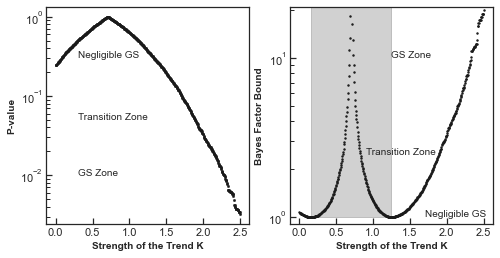

In [17]:
sns.set_style("ticks", {'xtick.direction': 'in', 'ytick.direction': 'in'})
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(8, 4))

##################################################################
# Constant vs p value
##################################################################
ax1.semilogy(results['Strength K'], results['p value'], 's',
         markerfacecolor='k', markeredgecolor='k', markeredgewidth=1,
         markersize=1.5, alpha=1)

ax1.text(0.3,0.01, 'GS Zone')
ax1.text(0.3,0.05, 'Transition Zone')
ax1.text(0.3,0.3, 'Negligible GS')

ax1.set_xlabel('Strength of the Trend K', fontsize=10,
               fontweight='bold')
ax1.set_ylabel('P-value', fontsize=10, fontweight='bold')

##################################################################
# Constant vs BFB
##################################################################
ax2.semilogy(results['Strength K'], results['BFB'], 'o',
         markerfacecolor='k', markeredgecolor='k', markeredgewidth=1,
         markersize=1.5, alpha=0.9)
ax2.set_ylim([.9, 21])

# Create a Rectangle patch
rect = patches.Rectangle((0.1603,1.),1.25-0.1603,results['BFB'].max(),
                         linewidth=1,edgecolor='k',facecolor='k',
                        alpha=0.2)
ax2.add_patch(rect) # Add the patch to the Axes

ax2.text(1.25, 10, 'GS Zone')
ax2.text(0.9,2.46, 'Transition Zone')
ax2.text(1.7,1., 'Negligible GS')

ax2.set_xlabel('Strength of the Trend K' , fontsize=10,
               fontweight='bold')
ax2.set_ylabel('Bayes Factor Bound', fontsize=10, fontweight='bold')

# ##################################################################
# # Save plot
# ##################################################################
fig.savefig('Fig7.tiff', dpi=700, format="tiff", bbox_inches='tight')

plt.show()

In [27]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=results['Strength K'], y=results['p value'], name="P value"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=results['Strength K'], y=results['BFB'], name="BFB"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Double Y Axis Example"
)

# Set x-axis title
fig.update_xaxes(title_text="xaxis title")

# Set y-axes titles
fig.update_yaxes(title_text="p value", secondary_y=False)
fig.update_yaxes(title_text="BFB", secondary_y=True)

fig.show()

In [19]:
results[results['Strength K'] < 0.1604]

p value  Effect Size  Variance Model       BFB  Strength K
0   0.242976    -0.413365        2.250000  1.070162    0.000000
1   0.246175    -0.420592        2.251135  1.066111    0.005010
2   0.248775    -0.427819        2.252382  1.062936    0.010020
3   0.252175    -0.435046        2.253743  1.058938    0.015030
4   0.256574    -0.442272        2.255217  1.054013    0.020040
5   0.258574    -0.449499        2.256803  1.051864    0.025050
6   0.262774    -0.456726        2.258503  1.047531    0.030060
7   0.264574    -0.463953        2.260315  1.045746    0.035070
8   0.267973    -0.471180        2.262240  1.042490    0.040080
9   0.271773    -0.478406        2.264279  1.039024    0.045090
10  0.274773    -0.485633        2.266430  1.036413    0.050100
11  0.279972    -0.492860        2.268694  1.032144    0.055110
12  0.283772    -0.500087        2.271071  1.029222    0.060120
13  0.287571    -0.507314        2.273562  1.026462    0.065130
14  0.292171    -0.514540        2.276165  1.023332    0.070140
15  0.296170    -0.521767        2.278881  1.020792    0.075150
16  0.301570    -0.528994        2.281710  1.017625    0.080160
17  0.306169    -0.536221        2.284652  1.015156    0.085170
18  0.309369    -0.543448        2.287706  1.013559    0.090180
19  0.314169    -0.550674        2.290874  1.011346    0.095190
20  0.317368    -0.557901        2.294155  1.009989    0.100200
21  0.323768    -0.565128        2.297549  1.007552    0.105210
22  0.328367    -0.572355        2.301056  1.006022    0.110220
23  0.332567    -0.579582        2.304675  1.004785    0.115230
24  0.336766    -0.586809        2.308408  1.003695    0.120240
25  0.341566    -0.594035        2.312253  1.002628    0.125251
26  0.346565    -0.601262        2.316212  1.001715    0.130261
27  0.350365    -0.608489        2.320283  1.001153    0.135271
28  0.353765    -0.615716        2.324468  1.000746    0.140281
29  0.357564    -0.622943        2.328765  1.000397    0.145291
30  0.360164    -0.630169        2.333175  1.000222    0.150301
31  0.364564    -0.637396        2.337699  1.000041    0.155311
32  0.367963    -0.644623        2.342335  1.000000    0.160321

In [18]:
# import plotly.express as px
px.scatter(data_frame=results, x='Strength K', y='BFB',
           template='plotly_white', log_y=True)

unreliable region 0.1603<K<1.2475

In [18]:
# import plotly.express as px
px.scatter(data_frame=results, x='Strength K', y='p value',
           template='plotly_white', log_y=True)

In [160]:
px.scatter(data_frame=results, x='p value', y='BFB',
           template='plotly_white')

when pvalue > 0.363, BFB not valid anymore

In [97]:
# lala.reshape(500, 10000).mean(axis=1)

array([15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15